In [1]:
import pandas as pd
import numpy as np
import torch as pt
from copy import deepcopy as copy
import matplotlib.pyplot as plt
%matplotlib inline

#pt.set_default_tensor_type('torch.FloatTensor')
pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from ml_lib.Controller import Controller as Control
#from ml_lib.clusters.root_cluster.RootCluster import RootCluster as Root
from ml_lib.clusters.data_cluster.DataCluster import DataCluster as Data
from ml_lib.clusters.learn_cluster.LearnCluster import LearnCluster as Learn

In [3]:
from ml_lib.clusters.learn_cluster.modules.learners.GradientLearner import GradientLearner
from ml_lib.clusters.learn_cluster.modules.learners.NewtonLearner import NewtonLearner
from ml_lib.clusters.learn_cluster.modules.learners.MomentumLearner import MomentumLearner
from ml_lib.clusters.learn_cluster.modules.learners.SmoothLearner import SmoothLearner

from ml_lib.clusters.learn_cluster.modules.activators.LinearActivate import LinearActivate
from ml_lib.clusters.learn_cluster.modules.activators.SigmoidActivate import SigmoidActivate
from ml_lib.clusters.learn_cluster.modules.activators.SoftMaxActivate import SoftMaxActivate
from ml_lib.clusters.learn_cluster.modules.activators.TanhActivator import TanhActivator
from ml_lib.clusters.learn_cluster.modules.activators.ReluActivator import ReluActivator

from ml_lib.clusters.data_cluster.losses.CrossEntLoss import CrossEntLoss

from ml_lib.clusters.data_cluster.splitters.BalanceSplit import BalanceSplit
from ml_lib.clusters.data_cluster.batchers.LowestBatch import LowestBatch

In [4]:
dataset = pd.get_dummies(pd.read_csv('data_files/mnist_train.csv'), columns = ['label'])
test_dataset = pd.read_csv('data_files/mnist_test.csv')
feature_cols = [col for col in dataset.columns if col.startswith('pixel')]
target_cols = [col for col in dataset.columns if col.startswith('label_')]
dataset[feature_cols] = dataset[feature_cols] / dataset[feature_cols].max().max()

In [16]:
verbose = False

learner = SmoothLearner
learner_kwargs = {
    'learn_rate': 1e-0
}

loss = CrossEntLoss
loss_kwargs = {}

activator = TanhActivator
activator_kwargs = {
    #'leak': 0.05
}

splitter = BalanceSplit
splitter_kwargs = {
    'balance_cols': dataset.columns.isin(target_cols).nonzero()[0]
}

batcher = LowestBatch
batcher_kwargs = {}

control = Control('regression_controller')

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter = splitter,
        splitter_kwargs = {'verbose': verbose, **splitter_kwargs},
        batcher = batcher,
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss = loss, loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)

control.link_add(
    Learn(
        'learn_cluster_1',
        module_kwargs = {
            'nodes': 128,
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1', 'input'
)

control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': SoftMaxActivate, 'activator_kwargs': {'verbose': verbose},
            'learner': learner, 'learner_kwargs': {'verbose': verbose, **learner_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_2', 'input'
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [17]:
control.train_model(1000)

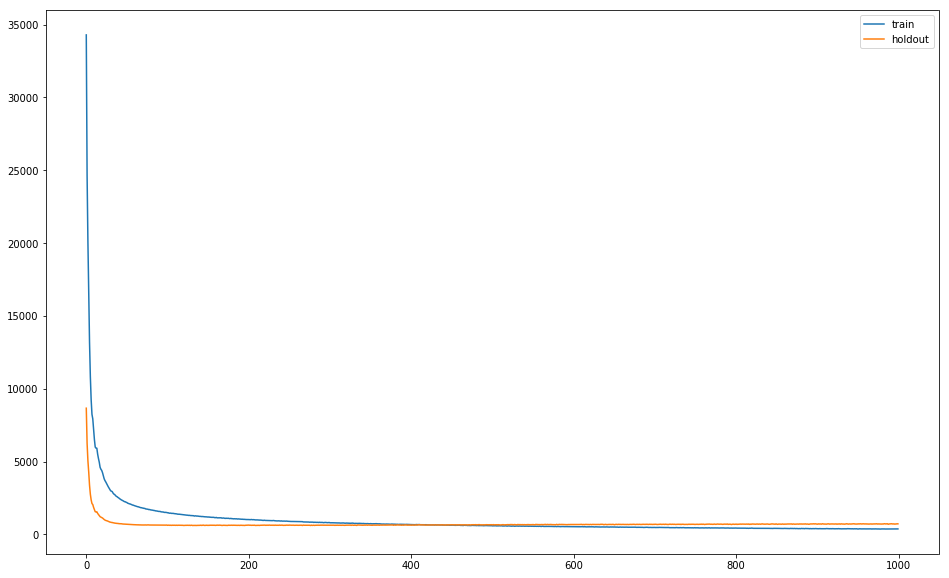

In [18]:
control.plot_losses()